# Checking out DESeq2 for Gene-level Differential analysis

Using mm9 genome so that the results can be more directly comparable to tables produced by elphege. We can see similarities and differences in the methods used for producing data relevant to DE analysis. 

In [1]:
library(DESeq2)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following objects are masked from 'package:base':

    I, expand.grid, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loading required package: SummarizedExperiment

Loading required package: MatrixGe

In [2]:
library("tximport")
library("rhdf5")
library(stringr)
library(dplyr)


Attaching package: 'dplyr'


The following object is masked from 'package:Biobase':

    combine


The following object is masked from 'package:matrixStats':

    count


The following objects are masked from 'package:GenomicRanges':

    intersect, setdiff, union


The following object is masked from 'package:GenomeInfoDb':

    intersect


The following objects are masked from 'package:IRanges':

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from 'package:S4Vectors':

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from 'package:BiocGenerics':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [3]:
# get location of kallisto outputs
elphege_proj_files = "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652"
sample_id <- dir(file.path(elphege_proj_files,"SRP106652"))
kal_dirs <- file.path(elphege_proj_files, "SRP106652", sample_id, "kallisto")
files <- file.path(kal_dirs, "abundance.h5")
names(files) <- str_split_fixed(files,'/',9)[,7]

In [7]:
# load conversion between transcripts and genes
ensembl_dir = "/project/fudenber_735/genomes/mm10/ensembl/ensembl_relational_downloads"
tx2gene <- read.csv(file.path(ensembl_dir,"biomaRt_mm10_t2g.csv"))[,-1]

In [5]:
# Getting "Run" and "condition" from Experiment Name of the SRA deposits
sra_summary <- read.table(
                    file.path(elphege_proj_files, 
                             "metadata", "sra_result_summary.csv"), 
                              header = TRUE, sep = ",", stringsAsFactors=FALSE)

# # Parse experiment name to get 'condition' -- str_split_fixed(string, pattern, n)
# # also Removing replicate number so that sleuth can do some grouping

conditions = data.frame(
                condition=str_split_fixed( str_split_fixed(
                             sra_summary$Experiment.Title,
                             "seq_", 4)[,2] ,'_rep',2)[,1])


# # putting replicate number as batch so that sleuth can do some grouping + controlling for batch
batches = data.frame(
                batch=str_split_fixed( str_split_fixed(
                sra_summary$Experiment.Title, 
                '_rep', 2)[,2], ';', 2)[,1])

sra_summary <- cbind(sra_summary,  conditions, batches)

    
run_info <- read.table(file.path(elphege_proj_files, "metadata", "SraRunInfo.csv"), header = TRUE, sep = ",", stringsAsFactors=FALSE)

# # merge sra_result file and sraRunInfo to get the condition
# # (buried in 'Experiment Name' in sra_result_summary -- put in 'condition')
sra_info_combined <- merge(run_info, sra_summary, 
                             by.x=c("Experiment"),
                             by.y=c("Experiment.Accession"),
                             all.x=TRUE)

s2c <- dplyr::select(sra_info_combined, Experiment, Run, condition, Library.Strategy, Library.Selection)
s2c <- dplyr::select(s2c, sample = Run, condition)
s2c$condition <- gsub('-', '_', s2c$condition) # apparently R wants  of factors in the design to only have letters, numbers, '_' and '.'
s2c$condition <- as.factor(s2c$condition)        # Convert character column to factor (not necessary, just suppresses warning below)

In [14]:
write.csv(s2c, file.path(elphege_proj_files, "metadata", "sample2condition.csv"))

In [7]:
s2c_untreated_vs_auxin1day <- s2c[ (s2c$condition=='CTCF_AID_untreated') | 
                               (s2c$condition=='CTCF_AID_auxin1day') , ]

files_untreated_vs_auxin1day = files[s2c_untreated_vs_auxin1day$sample]

In [8]:
#s2c_untreated_vs_auxin1day$condition
s2c_untreated_vs_auxin1day$condition <-  factor(s2c_untreated_vs_auxin1day$condition,
                                                levels = c("CTCF_AID_untreated", 'CTCF_AID_auxin1day'))

## to note from DESeq2:
# if you never tell the DESeq2 functions which level you want to compare against 
# (e.g. which level represents the control group), the comparisons will be based
# on the alphabetical order of the levels

In [4]:
tx_by_genes <- tximport(
                 files_untreated_vs_auxin1day,
                 type = "kallisto", 
                 tx2gene = tx2gene, 
                 ignoreAfterBar = TRUE, 
                )

# note: transcript-level loading can also be done with tximport
#txi <- tximport( files, type="kallisto", txOut=TRUE)

ERROR: Error in file.exists(files): object 'files_untreated_vs_auxin1day' not found


In [10]:
s2c_untreated_vs_auxin1day

,sample,condition
,<chr>,<fct>
1,SRR5517500,CTCF_AID_untreated
2,SRR5517501,CTCF_AID_auxin1day
6,SRR5517505,CTCF_AID_untreated
7,SRR5517506,CTCF_AID_auxin1day
11,SRR5517510,CTCF_AID_untreated
12,SRR5517511,CTCF_AID_auxin1day


In [11]:
dds <- DESeqDataSetFromTximport(tx_by_genes,
                                colData = s2c_untreated_vs_auxin1day,
                                design = ~ condition)

using counts and average transcript lengths from tximport



In [12]:
dds <- DESeq(dds)

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [13]:
head(results(dds), 3)

log2 fold change (MLE): condition CTCF AID auxin1day vs CTCF AID untreated 
Wald test p-value: condition CTCF AID auxin1day vs CTCF AID untreated 
DataFrame with 3 rows and 6 columns
                    baseMean log2FoldChange     lfcSE      stat    pvalue
                   <numeric>      <numeric> <numeric> <numeric> <numeric>
ENSMUSG00000000001   4946.92     -0.0308229  0.252413 -0.122113  0.902809
ENSMUSG00000000003      0.00             NA        NA        NA        NA
ENSMUSG00000000028   2277.24     -0.0917477  0.176626 -0.519447  0.603449
                        padj
                   <numeric>
ENSMUSG00000000001  0.999976
ENSMUSG00000000003        NA
ENSMUSG00000000028  0.999976

In [13]:
dim(results(dds))

[1] 26520     6

In [14]:
res <- results(dds, name='condition_CTCF_AID_auxin1day_vs_CTCF_AID_untreated')

In [15]:
res05 <- results(dds, alpha=0.05)


In [16]:
summary(res05)


out of 22072 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 130, 0.59%
LFC < 0 (down)     : 159, 0.72%
outliers [1]       : 86, 0.39%
low counts [2]     : 5504, 25%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



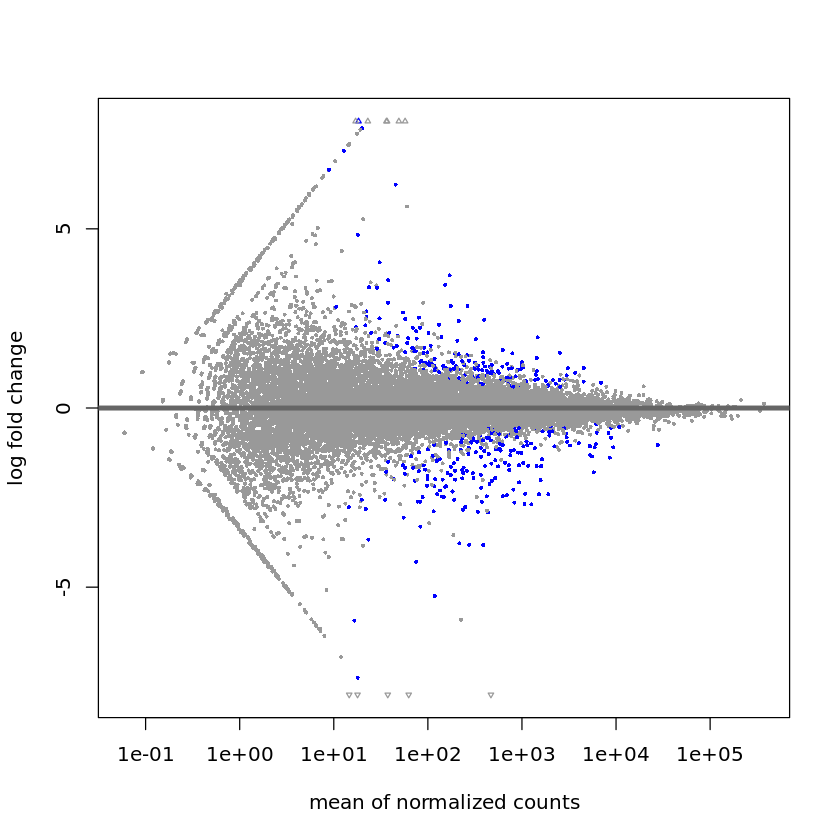

In [17]:
plotMA(res, ylim=c(-8,8))


In [8]:
tx_by_genes_all <- tximport(
                 files,
                 type = "kallisto", 
                 tx2gene = tx2gene, 
                 ignoreAfterBar = TRUE, 
                )

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 


transcripts missing from tx2gene: 8427

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates



In [11]:
head(tx_by_genes_all$counts)

,SRR5517500,SRR5517501,SRR5517502,SRR5517503,SRR5517504,SRR5517505,SRR5517506,SRR5517507,SRR5517508,SRR5517509,⋯,SRR5517514,SRR5517515,SRR5517516,SRR5517517,SRR5517518,SRR5517519,SRR5517520,SRR5517521,SRR5517522,SRR5517523
ENSMUSG00000000001,2068.00000,1859.0000,2966.0000,2545.0000,2211.0000,4792.00000,5192.0000,5233.0000,4693.000,6473.0000,⋯,9352.0000,7182.0000,12709.0000,18706.0000,11184.0000,1230,6731.0000,12695.0000,7882.0000,5317.0000
ENSMUSG00000000003,0.00000,0.0000,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,0.000,1.0000,⋯,0.0000,0.0000,0.0000,0.0000,0.0000,0,1.0000,0.0000,0.0000,0.0000
ENSMUSG00000000028,1049.00000,1252.0000,1377.0000,900.0000,1174.0000,2102.00000,1886.0000,1927.0000,1984.000,2568.0000,⋯,3956.0000,2650.0000,5790.0000,6500.0000,3913.0000,852,2105.0000,4494.0000,2550.0815,1572.0000
ENSMUSG00000000031,21.00000,20.0000,19.0000,21.0000,35.0000,27.00000,19.0000,21.0000,68.000,90.0000,⋯,82.0000,411.0000,1083.0000,1286.0000,1621.0000,443,1100.0000,873.0000,487.0000,291.0000
ENSMUSG00000000037,57.24222,125.6492,535.8678,314.4085,114.8587,97.35308,699.3419,883.2799,743.272,333.0103,⋯,489.0157,184.8858,345.0086,507.4915,357.7912,75,219.3036,253.2669,208.8918,123.2886
ENSMUSG00000000049,0.00000,0.0000,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,2.000,0.0000,⋯,1.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000


In [10]:
# exporting abundances for all genes
write.csv(tx_by_genes_all$counts, file.path(elphege_proj_files, "deseq-mm10-results", "tximport", "gene-counts.csv"))

In [ ]:
dds_all <- DESeqDataSetFromTximport(tx_by_genes_all,
                                colData = s2c,
                                design = ~ condition)

In [19]:
vsd_all <- vst(dds_all, blind=FALSE)


using 'avgTxLength' from assays(dds), correcting for library size



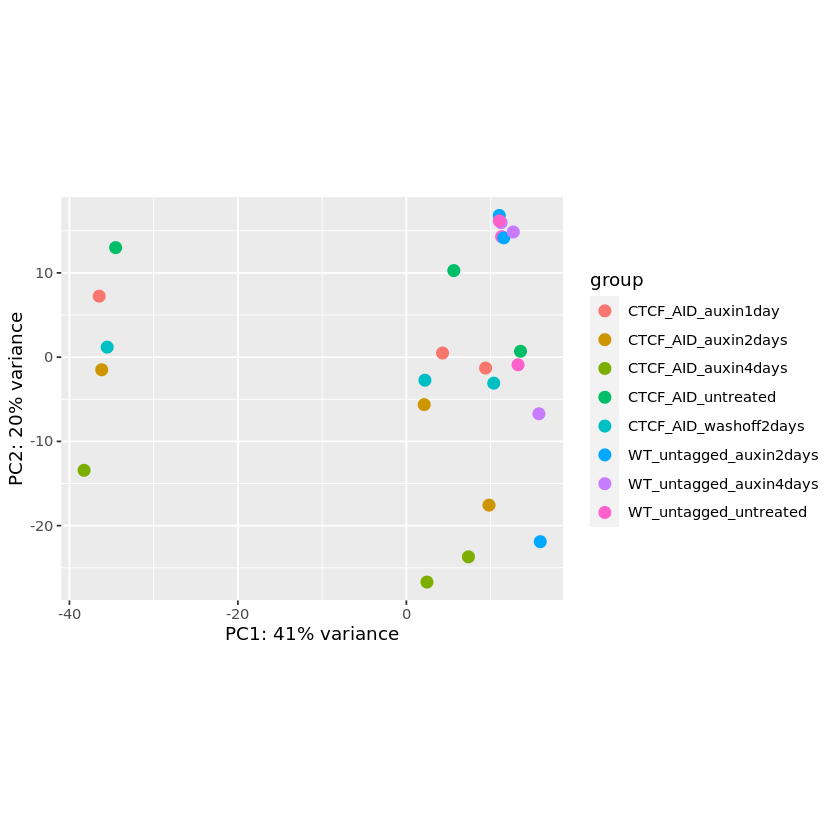

In [20]:
plotPCA(vsd_all)

In [21]:
print(levels(s2c$condition))




[1] "CTCF_AID_auxin1day"     "CTCF_AID_auxin2days"    "CTCF_AID_auxin4days"   
[4] "CTCF_AID_untreated"     "CTCF_AID_washoff2days"  "WT_untagged_auxin2days"
[7] "WT_untagged_auxin4days" "WT_untagged_untreated" 


## Pairwise deseq for genes for rest of conditions

In [15]:
 ## saving all .csvs and getting summaries to generate heatmaps for all of these conditions
for (cond in levels(s2c$condition)) {
    
    if (cond != 'CTCF_AID_untreated') {
        
        print(paste("Performing test for condition:", cond))
        
        s2c_untreated_vs_variable <- s2c[ (s2c$condition=='CTCF_AID_untreated') | 
                                       (s2c$condition==cond) , ]

        files_untreated_vs_variable = files[s2c_untreated_vs_variable$sample]

        s2c_untreated_vs_variable$condition <-  factor(s2c_untreated_vs_variable$condition,
                                                    levels = c("CTCF_AID_untreated", cond))
        tx_by_genes <- tximport(
                 files_untreated_vs_variable,
                 type = "kallisto", 
                 tx2gene = tx2gene, 
                 ignoreAfterBar = TRUE, 
                )
        
        print("Variables in design ~condition looks like: ")
        print(~ condition)
        
        dds <- DESeqDataSetFromTximport(tx_by_genes,
                                colData = s2c_untreated_vs_variable,
                                design = ~ condition)
        
        
        dds <- DESeq(dds)
        
        res <- results(dds, name=paste('condition_', cond, '_vs_CTCF_AID_untreated', sep=""), alpha=0.05)
        
        print(head(res, 6))
        
        # save as .csv so can generate heat plots, analyze elsewhere, etc
        write.csv(res,file.path(elphege_proj_files, "deseq-mm10-results", paste("pairwise_deseq_wt_", cond, ".csv", sep="")))
        
        # printing some general stats about the significant set
        print(summary(results(dds, alpha=0.05)))
        
    }
    
}

[1] "Performing test for condition: CTCF_AID_auxin1day"


1 
2 
3 
4 
5 
6 


transcripts missing from tx2gene: 8427

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates



[1] "Variables in design ~condition looks like: "
~condition


using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



log2 fold change (MLE): condition CTCF AID auxin1day vs CTCF AID untreated 
Wald test p-value: condition CTCF AID auxin1day vs CTCF AID untreated 
DataFrame with 6 rows and 6 columns
                    baseMean log2FoldChange     lfcSE      stat      pvalue
                   <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSMUSG00000000001 4946.9216     -0.0308229  0.252413 -0.122113 9.02809e-01
ENSMUSG00000000003    0.0000             NA        NA        NA          NA
ENSMUSG00000000028 2277.2352     -0.0917477  0.176626 -0.519447 6.03449e-01
ENSMUSG00000000031   27.6991     -0.3298840  0.641314 -0.514388 6.06981e-01
ENSMUSG00000000037  330.5182      2.0200113  0.509448  3.965098 7.33658e-05
ENSMUSG00000000049    0.0000             NA        NA        NA          NA
                         padj
                    <numeric>
ENSMUSG00000000001 0.99997628
ENSMUSG00000000003         NA
ENSMUSG00000000028 0.99997628
ENSMUSG00000000031 0.99997628
ENSMUSG00000000037 0.00728352

1 
2 
3 
4 
5 
6 


transcripts missing from tx2gene: 8427

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates



[1] "Variables in design ~condition looks like: "
~condition


using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



log2 fold change (MLE): condition CTCF AID auxin2days vs CTCF AID untreated 
Wald test p-value: condition CTCF AID auxin2days vs CTCF AID untreated 
DataFrame with 6 rows and 6 columns
                    baseMean log2FoldChange     lfcSE      stat      pvalue
                   <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSMUSG00000000001 5001.9591      -0.148058  0.222614 -0.665088 5.05994e-01
ENSMUSG00000000003    0.0000             NA        NA        NA          NA
ENSMUSG00000000028 2244.6738      -0.302052  0.191133 -1.580322 1.14033e-01
ENSMUSG00000000031   28.3536      -0.100458  0.620469 -0.161906 8.71380e-01
ENSMUSG00000000037  433.3437       2.512400  0.320592  7.836763 4.62310e-15
ENSMUSG00000000049    0.0000             NA        NA        NA          NA
                          padj
                     <numeric>
ENSMUSG00000000001 9.23888e-01
ENSMUSG00000000003          NA
ENSMUSG00000000028 5.54805e-01
ENSMUSG00000000031 9.90942e-01
ENSMUSG00000000037 2.

1 
2 
3 
4 
5 
6 


transcripts missing from tx2gene: 8427

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates



[1] "Variables in design ~condition looks like: "
~condition


using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



log2 fold change (MLE): condition CTCF AID auxin4days vs CTCF AID untreated 
Wald test p-value: condition CTCF AID auxin4days vs CTCF AID untreated 
DataFrame with 6 rows and 6 columns
                      baseMean log2FoldChange     lfcSE      stat      pvalue
                     <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSMUSG00000000001 4948.928170      -0.158858  0.200859 -0.790893 4.29006e-01
ENSMUSG00000000003    0.000000             NA        NA        NA          NA
ENSMUSG00000000028 2129.077342      -0.433839  0.180891 -2.398340 1.64696e-02
ENSMUSG00000000031   38.635521       0.724092  0.553304  1.308671 1.90646e-01
ENSMUSG00000000037  379.427633       2.157000  0.299316  7.206440 5.74338e-13
ENSMUSG00000000049    0.816414       3.147246  3.577265  0.879791 3.78973e-01
                          padj
                     <numeric>
ENSMUSG00000000001 6.78132e-01
ENSMUSG00000000003          NA
ENSMUSG00000000028 7.11982e-02
ENSMUSG00000000031 4.14096e-01
ENSMU

1 
2 
3 
4 
5 
6 


transcripts missing from tx2gene: 8427

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates



[1] "Variables in design ~condition looks like: "
~condition


using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



log2 fold change (MLE): condition CTCF AID washoff2days vs CTCF AID untreated 
Wald test p-value: condition CTCF AID washoff2days vs CTCF AID untreated 
DataFrame with 6 rows and 6 columns
                      baseMean log2FoldChange     lfcSE      stat    pvalue
                     <numeric>      <numeric> <numeric> <numeric> <numeric>
ENSMUSG00000000001 5192.404215      0.0244910  0.233400  0.104932 0.9164301
ENSMUSG00000000003    0.140060      1.0783969  4.070709  0.264916 0.7910740
ENSMUSG00000000028 2371.726261     -0.0645147  0.196175 -0.328863 0.7422591
ENSMUSG00000000031   51.086003      1.3586945  0.563756  2.410074 0.0159493
ENSMUSG00000000037  194.658852      1.0106096  0.318469  3.173333 0.0015070
ENSMUSG00000000049    0.106074      0.9642415  4.074714  0.236640 0.8129359
                        padj
                   <numeric>
ENSMUSG00000000001 0.9999880
ENSMUSG00000000003        NA
ENSMUSG00000000028 0.9999880
ENSMUSG00000000031 0.4529011
ENSMUSG00000000037 0.0986712


1 
2 
3 
4 
5 
6 


transcripts missing from tx2gene: 8427

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates



[1] "Variables in design ~condition looks like: "
~condition


using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



log2 fold change (MLE): condition WT untagged auxin2days vs CTCF AID untreated 
Wald test p-value: condition WT untagged auxin2days vs CTCF AID untreated 
DataFrame with 6 rows and 6 columns
                    baseMean log2FoldChange     lfcSE       stat      pvalue
                   <numeric>      <numeric> <numeric>  <numeric>   <numeric>
ENSMUSG00000000001  5474.841      0.0102988  0.478707  0.0215137 9.82836e-01
ENSMUSG00000000003     0.000             NA        NA         NA          NA
ENSMUSG00000000028  2434.608     -0.1331290  0.349009 -0.3814488 7.02870e-01
ENSMUSG00000000031   312.997      4.2142904  0.490700  8.5883162 8.82531e-18
ENSMUSG00000000037   154.702      0.2352174  0.465551  0.5052455 6.13386e-01
ENSMUSG00000000049     0.000             NA        NA         NA          NA
                         padj
                    <numeric>
ENSMUSG00000000001 9.9994e-01
ENSMUSG00000000003         NA
ENSMUSG00000000028 9.9994e-01
ENSMUSG00000000031 9.2529e-14
ENSMUSG000000

1 
2 
3 
4 
5 
6 


transcripts missing from tx2gene: 8427

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates



[1] "Variables in design ~condition looks like: "
~condition


using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



log2 fold change (MLE): condition WT untagged auxin4days vs CTCF AID untreated 
Wald test p-value: condition WT untagged auxin4days vs CTCF AID untreated 
DataFrame with 6 rows and 6 columns
                      baseMean log2FoldChange     lfcSE      stat      pvalue
                     <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSMUSG00000000001 6848.932736       0.400170  0.206748  1.935545 5.29235e-02
ENSMUSG00000000003    0.165093       0.855741  4.054581  0.211055 8.32844e-01
ENSMUSG00000000028 2626.234836      -0.180206  0.197151 -0.914049 3.60691e-01
ENSMUSG00000000031  366.997700       4.347430  0.467961  9.290158 1.54060e-20
ENSMUSG00000000037  175.036980       0.423305  0.285896  1.480628 1.38706e-01
ENSMUSG00000000049    0.000000             NA        NA        NA          NA
                          padj
                     <numeric>
ENSMUSG00000000001 5.18853e-01
ENSMUSG00000000003          NA
ENSMUSG00000000028 7.99485e-01
ENSMUSG00000000031 1.24634e-16

1 
2 
3 
4 
5 
6 


transcripts missing from tx2gene: 8427

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates



[1] "Variables in design ~condition looks like: "
~condition


using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



log2 fold change (MLE): condition WT untagged untreated vs CTCF AID untreated 
Wald test p-value: condition WT untagged untreated vs CTCF AID untreated 
DataFrame with 6 rows and 6 columns
                    baseMean log2FoldChange     lfcSE      stat      pvalue
                   <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSMUSG00000000001  7307.100       0.296431  0.189243  1.566401 1.17255e-01
ENSMUSG00000000003     0.000             NA        NA        NA          NA
ENSMUSG00000000028  2982.190      -0.121074  0.179385 -0.674937 4.99716e-01
ENSMUSG00000000031   362.703       4.168079  0.449292  9.276999 1.74319e-20
ENSMUSG00000000037   179.959       0.347245  0.255703  1.358000 1.74464e-01
ENSMUSG00000000049     0.000             NA        NA        NA          NA
                          padj
                     <numeric>
ENSMUSG00000000001 7.95288e-01
ENSMUSG00000000003          NA
ENSMUSG00000000028 9.33692e-01
ENSMUSG00000000031 1.07938e-16
ENSMUSG0000000003

# Controlling for batch effect in DESeq



In [22]:
str_split_fixed( str_split_fixed(
    sra_summary$Experiment.Title[1], 
    '_rep', 2)[,2], ';', 2)[,1]

[1] "3"

In [23]:
# ## note: added this segment above, during initial loading (putting here for ref)
# batches = data.frame(
#                 batch=str_split_fixed( str_split_fixed(
#                 sra_summary$Experiment.Title, 
#                 '_rep', 2)[,2], ';', 2)[,1])

# sra_summary <- cbind(sra_summary,  conditions, batches)

# setting up experiment to include both condition and replicate number
s2condition_batch <- dplyr::select(sra_info_combined, Experiment, Run, condition, batch, Library.Strategy, Library.Selection)
s2condition_batch <- dplyr::select(s2condition_batch, sample = Run, condition, batch)
s2condition_batch$condition <- gsub('-', '_', s2condition_batch$condition) # apparently R wants  of factors in the design to only have letters, numbers, '_' and '.'
s2condition_batch$condition <- as.factor(s2condition_batch$condition)        # Convert character column to factor (not necessary, just suppresses warning below)

## Looking at impact of batch

In [24]:
tx_by_genes_all_batch <- tximport(
                 files[s2condition_batch$sample],
                 type = "kallisto", 
                 tx2gene = tx2gene, 
                 ignoreAfterBar = TRUE, 
                )

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 


removing duplicated transcript rows from tx2gene

transcripts missing from tx2gene: 47421

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates



In [25]:
## Training model with all and looking at quality of data
dds_all_batch <- DESeqDataSetFromTximport(tx_by_genes_all_batch,
                                colData = s2condition_batch,
                                design = ~batch + condition )


Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
using counts and average transcript lengths from tximport



using 'avgTxLength' from assays(dds), correcting for library size



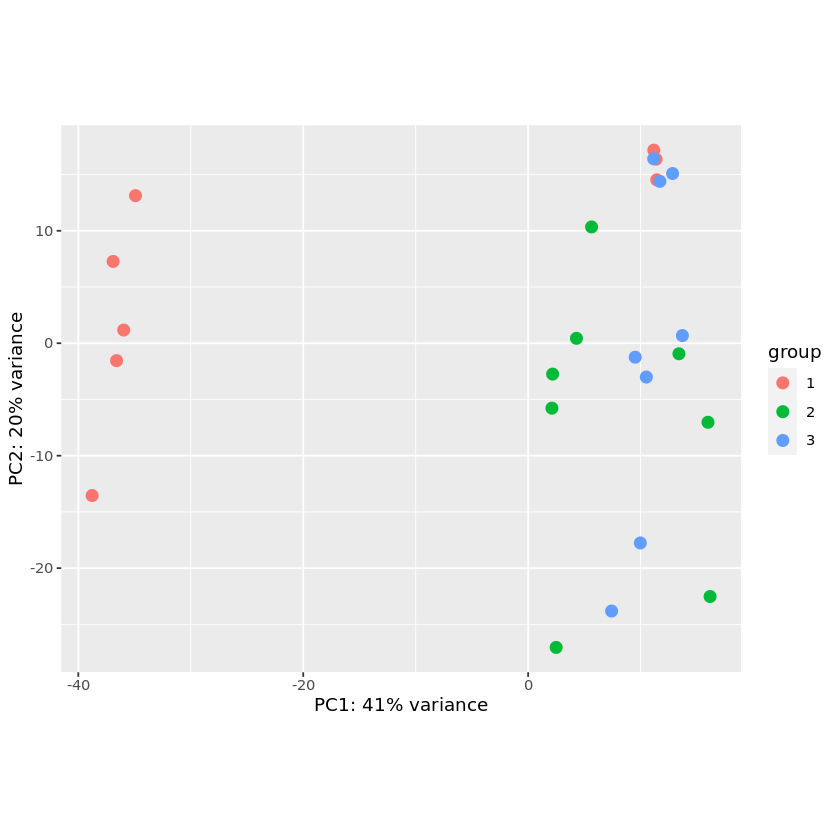

In [26]:
vsd_batch <- vst(dds_all_batch)

plotPCA(vsd_batch, intgroup=c("batch"))

In [27]:
library(ggplot2)

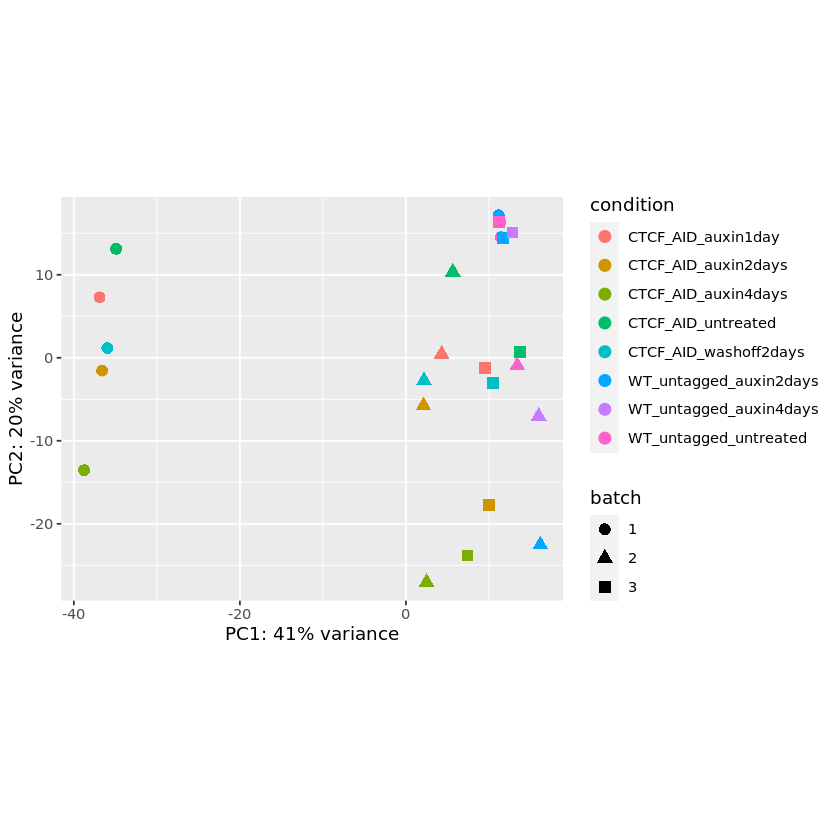

In [28]:
pcaData <- plotPCA(vsd_batch, intgroup=c("condition", "batch"), returnData=TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))
ggplot(pcaData, aes(PC1, PC2, color=condition, shape=batch)) +
  geom_point(size=3) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed()

In [35]:
# Try removing replicate 1
s2condition_batch_no1 <- s2condition_batch[s2condition_batch$batch != 1, ]

tx_by_genes_subtracted_batch <- tximport(
                 files[s2condition_batch_no1$sample],
                 type = "kallisto", 
                 tx2gene = tx2gene, 
                 ignoreAfterBar = TRUE, 
                )

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 


removing duplicated transcript rows from tx2gene

transcripts missing from tx2gene: 47421

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates



In [37]:
dds_sub_batch <- DESeqDataSetFromTximport(tx_by_genes_subtracted_batch,
                                colData = s2condition_batch_no1,
                                design = ~batch + condition )

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
using counts and average transcript lengths from tximport



using 'avgTxLength' from assays(dds), correcting for library size



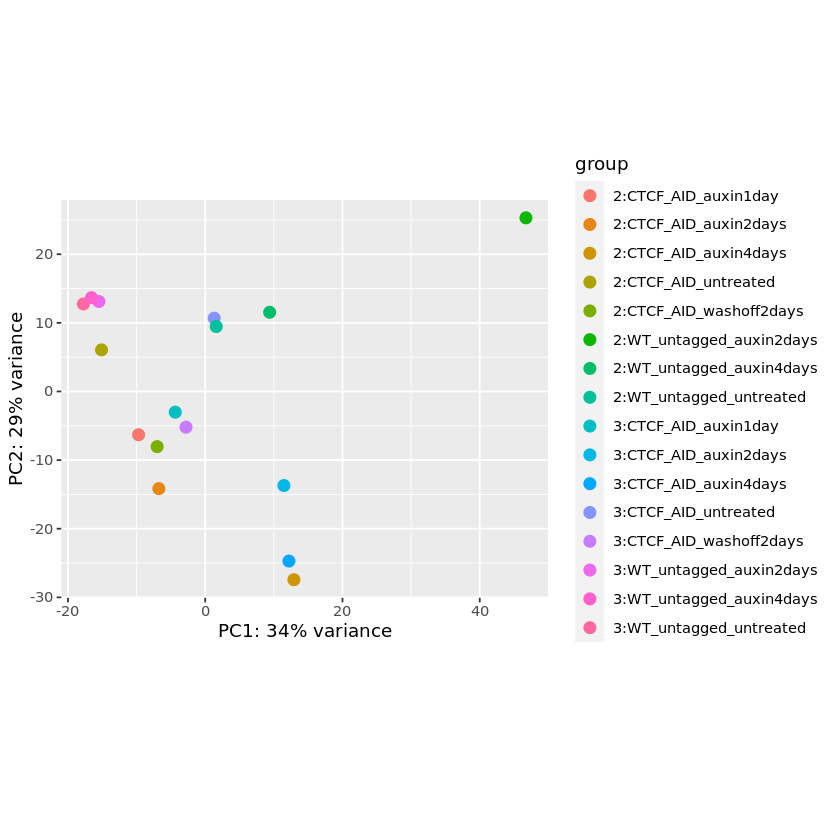

In [39]:
vsd_sub_batch <- vst(dds_sub_batch)

plotPCA(vsd_sub_batch, intgroup=c("batch", "condition"))

In [25]:
# Looking at model set up for adding batch to s2c
s2c_untreated_vs_variable <- s2condition_batch[ 
                                (s2condition_batch$condition=='CTCF_AID_untreated') | 
                                (s2condition_batch$condition=='CTCF_AID_auxin1day') , ]

files_untreated_vs_variable = files[s2c_untreated_vs_variable$sample]

s2c_untreated_vs_variable$condition <-  factor(s2c_untreated_vs_variable$condition,
                                            levels = c("CTCF_AID_untreated", 'CTCF_AID_auxin1day'))

s2c_untreated_vs_variable$batch <- factor(s2c_untreated_vs_variable$batch)

In [26]:
s2c_untreated_vs_variable

,sample,condition,batch
,<chr>,<fct>,<fct>
1,SRR5517500,CTCF_AID_untreated,1
2,SRR5517501,CTCF_AID_auxin1day,1
6,SRR5517505,CTCF_AID_untreated,2
7,SRR5517506,CTCF_AID_auxin1day,2
11,SRR5517510,CTCF_AID_untreated,3
12,SRR5517511,CTCF_AID_auxin1day,3


In [27]:
model.matrix(~s2c_untreated_vs_variable$batch + s2c_untreated_vs_variable$condition)

,(Intercept),s2c_untreated_vs_variable$batch2,s2c_untreated_vs_variable$batch3,s2c_untreated_vs_variable$conditionCTCF_AID_auxin1day
1,1,0,0,0
2,1,0,0,1
3,1,1,0,0
4,1,1,0,1
5,1,0,1,0
6,1,0,1,1


In [28]:
tx_by_genes_all <- tximport(
                 files_untreated_vs_variable,
                 type = "kallisto", 
                 tx2gene = tx2gene, 
                 ignoreAfterBar = TRUE, 
                )
dds_batch <- DESeqDataSetFromTximport(tx_by_genes_all,
                                colData = s2c_untreated_vs_variable,
                                design = ~batch + condition)

1 
2 
3 
4 
5 
6 


removing duplicated transcript rows from tx2gene

transcripts missing from tx2gene: 47421

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates

using counts and average transcript lengths from tximport



In [29]:
dds_batch <- DESeq(dds_batch)

res <- results(dds_batch)

head(res, 10)

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



log2 fold change (MLE): condition CTCF AID auxin1day vs CTCF AID untreated 
Wald test p-value: condition CTCF AID auxin1day vs CTCF AID untreated 
DataFrame with 10 rows and 6 columns
                    baseMean log2FoldChange     lfcSE      stat      pvalue
                   <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSMUSG00000000001 4942.4579     -0.0514565 0.1090935 -0.471673 6.37160e-01
ENSMUSG00000000003    0.0000             NA        NA        NA          NA
ENSMUSG00000000028 2278.3352     -0.0984831 0.1135039 -0.867663 3.85579e-01
ENSMUSG00000000037  398.3251      2.4686875 0.1922132 12.843487 9.35638e-38
ENSMUSG00000000049    0.0000             NA        NA        NA          NA
ENSMUSG00000000056  667.8164     -0.0883968 0.1393911 -0.634164 5.25974e-01
ENSMUSG00000000058   15.9514      0.9085348 0.8733456  1.040292 2.98204e-01
ENSMUSG00000000078 1667.1759      0.2189450 0.1577203  1.388185 1.65081e-01
ENSMUSG00000000085  632.1845     -0.5835157 0.1758538 -3

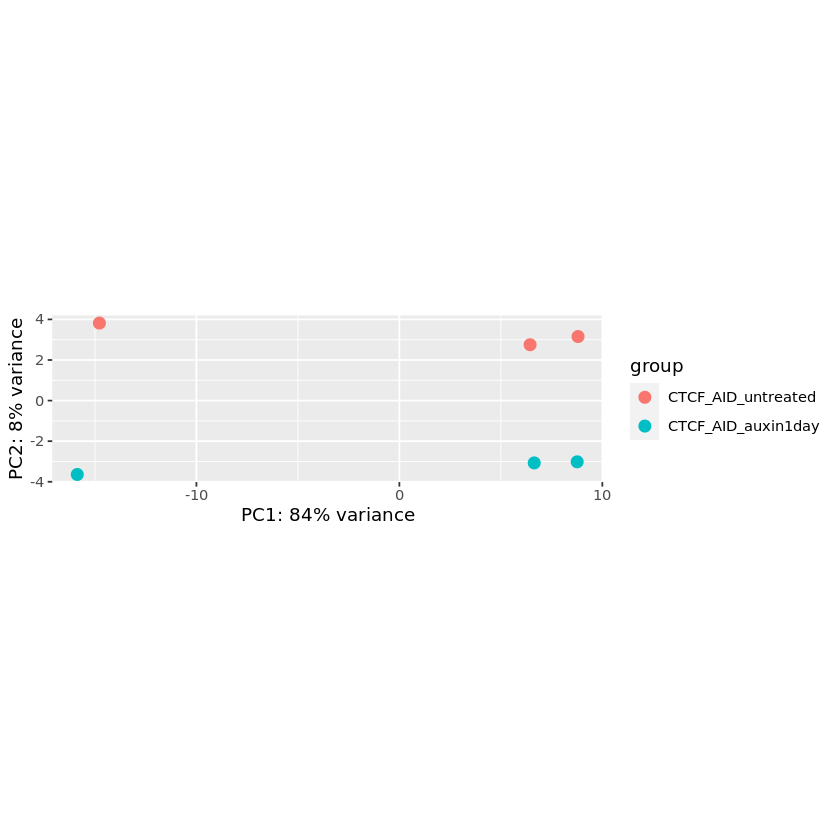

In [30]:
vsd_all <- vst(dds_batch, blind=FALSE)
plotPCA(vsd_all)

using counts and average transcript lengths from tximport

using 'avgTxLength' from assays(dds), correcting for library size



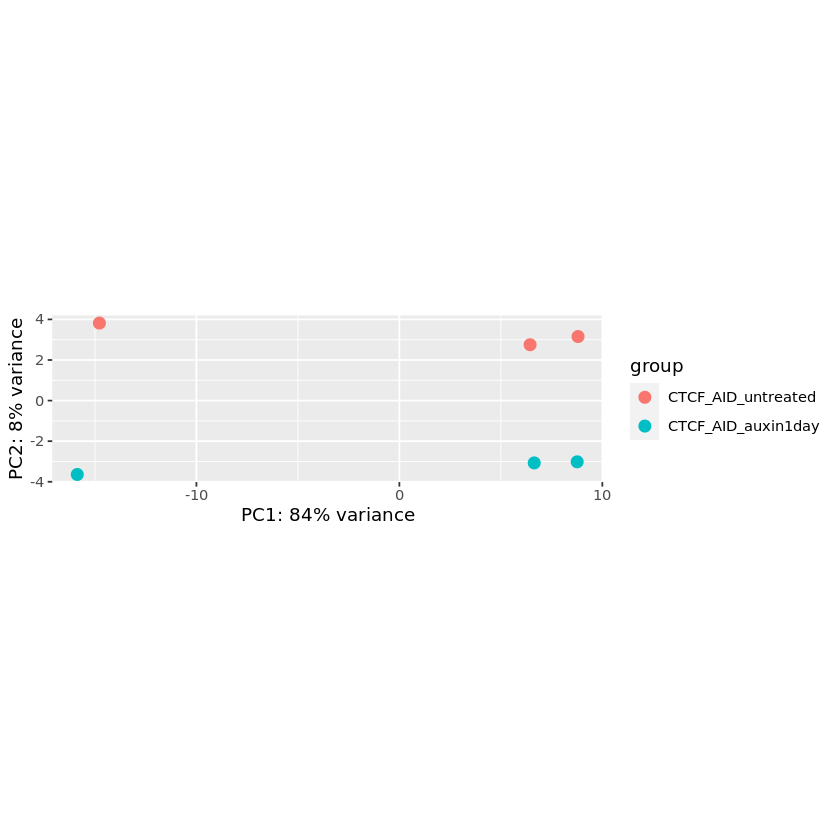

In [65]:
dds_alt <- DESeqDataSetFromTximport(tx_by_genes_all,
                                colData = s2c_untreated_vs_variable,
                                design = ~ condition + batch)
vsd_alt <- vst(dds_alt, blind=FALSE)
plotPCA(vsd_alt)

In [28]:
 ## saving all .csvs and getting summaries to generate heatmaps for all of these conditions
for (cond in levels(s2condition_batch$condition)) {
    
    if (cond != 'CTCF_AID_untreated') {
        
        print(paste("Performing test for condition:", cond))
        
        s2c_untreated_vs_variable <- s2condition_batch[ 
                                        (s2condition_batch$condition=='CTCF_AID_untreated') | 
                                        (s2condition_batch$condition==cond) , ]

        files_untreated_vs_variable = files[s2c_untreated_vs_variable$sample]

        s2c_untreated_vs_variable$condition <-  factor(s2c_untreated_vs_variable$condition,
                                                    levels = c("CTCF_AID_untreated", cond))
        
        s2c_untreated_vs_variable$batch <- factor(s2c_untreated_vs_variable$batch)
        
        
        tx_by_genes <- tximport(
                 files_untreated_vs_variable,
                 type = "kallisto", 
                 tx2gene = tx2gene, 
                 ignoreAfterBar = TRUE, 
                )

        
        dds <- DESeqDataSetFromTximport(tx_by_genes,
                                colData = s2c_untreated_vs_variable,
                                design = ~ batch + condition)
        
        
        dds <- DESeq(dds)
        
        res <- results(dds, name=paste('condition_', cond, '_vs_CTCF_AID_untreated', sep=""))
        
        # save as .csv so can generate heat plots, analyze elsewhere, etc
        write.csv(res,file.path(elphege_proj_files, "deseq-mm9-results", paste("pairwise_batch_deseq_wt_", cond, ".csv", sep="")))
        
        # printing some general stats about the significant set
        print(summary(results(dds, alpha=0.05)))
        
    }
    
}

[1] "Performing test for condition: CTCF_AID_auxin1day"


1 
2 
3 
4 
5 
6 


removing duplicated transcript rows from tx2gene

transcripts missing from tx2gene: 47421

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates

using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




out of 22072 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 539, 2.4%
LFC < 0 (down)     : 759, 3.4%
outliers [1]       : 0, 0%
low counts [2]     : 8891, 40%
(mean count < 30)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL
[1] "Performing test for condition: CTCF_AID_auxin2days"


1 
2 
3 
4 
5 
6 


removing duplicated transcript rows from tx2gene

transcripts missing from tx2gene: 47421

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates

using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




out of 22266 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1458, 6.5%
LFC < 0 (down)     : 2301, 10%
outliers [1]       : 0, 0%
low counts [2]     : 6410, 29%
(mean count < 8)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL
[1] "Performing test for condition: CTCF_AID_auxin4days"


1 
2 
3 
4 
5 
6 


removing duplicated transcript rows from tx2gene

transcripts missing from tx2gene: 47421

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates

using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




out of 22572 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 3130, 14%
LFC < 0 (down)     : 3602, 16%
outliers [1]       : 0, 0%
low counts [2]     : 5637, 25%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL
[1] "Performing test for condition: CTCF_AID_washoff2days"


1 
2 
3 
4 
5 
6 


removing duplicated transcript rows from tx2gene

transcripts missing from tx2gene: 47421

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates

using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




out of 22287 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 518, 2.3%
LFC < 0 (down)     : 462, 2.1%
outliers [1]       : 0, 0%
low counts [2]     : 7700, 35%
(mean count < 15)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL
[1] "Performing test for condition: WT_untagged_auxin2days"


1 
2 
3 
4 
5 
6 


removing duplicated transcript rows from tx2gene

transcripts missing from tx2gene: 47421

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates

using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




out of 22157 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 9, 0.041%
LFC < 0 (down)     : 7, 0.032%
outliers [1]       : 0, 0%
low counts [2]     : 6377, 29%
(mean count < 9)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL
[1] "Performing test for condition: WT_untagged_auxin4days"


1 
2 
3 
4 
5 
6 


removing duplicated transcript rows from tx2gene

transcripts missing from tx2gene: 47421

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates

using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




out of 22811 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 33, 0.14%
LFC < 0 (down)     : 36, 0.16%
outliers [1]       : 0, 0%
low counts [2]     : 7016, 31%
(mean count < 8)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL
[1] "Performing test for condition: WT_untagged_untreated"


1 
2 
3 
4 
5 
6 


removing duplicated transcript rows from tx2gene

transcripts missing from tx2gene: 47421

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates

using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




out of 22697 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 17, 0.075%
LFC < 0 (down)     : 19, 0.084%
outliers [1]       : 0, 0%
low counts [2]     : 6106, 27%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL
